# **EVALUATING THE OPENLLMs FOR THE TEXT SUMMARIZATION**

In this notebook, I have used the CNN-Dailymail Text summarization of the Newspaper. I have used the three OpenLLMs model for text summarization.
The Models are: **Facebook-BART**, **T5(Text-to-text Transformer)**, **DistilBERT**.

## IMPORTING NECESSARY LIBRARIES

In [58]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BartTokenizer, BartForConditionalGeneration, TrainingArguments, Trainer

In [59]:
# Load the dataset
train_path = "/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv"
validation_path = "/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv"
test_path = "/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv"

In [60]:
train_df = pd.read_csv(train_path)
validation_df = pd.read_csv(validation_path)
test_df = pd.read_csv(test_path)

In [61]:
# Display the first few rows of the dataset
print("Train Dataset - Sample Rows:")
print(train_df.head())

Train Dataset - Sample Rows:
                                         id  \
0  0001d1afc246a7964130f43ae940af6bc6c57f01   
1  0002095e55fcbd3a2f366d9bf92a95433dc305ef   
2  00027e965c8264c35cc1bc55556db388da82b07f   
3  0002c17436637c4fe1837c935c04de47adb18e9a   
4  0003ad6ef0c37534f80b55b4235108024b407f0b   

                                             article  \
0  By . Associated Press . PUBLISHED: . 14:11 EST...   
1  (CNN) -- Ralph Mata was an internal affairs li...   
2  A drunk driver who killed a young woman in a h...   
3  (CNN) -- With a breezy sweep of his pen Presid...   
4  Fleetwood are the only team still to have a 10...   

                                          highlights  
0  Bishop John Folda, of North Dakota, is taking ...  
1  Criminal complaint: Cop used his role to help ...  
2  Craig Eccleston-Todd, 27, had drunk at least t...  
3  Nina dos Santos says Europe must be ready to a...  
4  Fleetwood top of League One after 2-0 win at S...  


In [62]:
# Summary statistics
print("Train Dataset - Summary Statistics:")
print(train_df.describe())

Train Dataset - Summary Statistics:
                                              id  \
count                                     287113   
unique                                    287113   
top     0001d1afc246a7964130f43ae940af6bc6c57f01   
freq                                           1   

                                                  article  \
count                                              287113   
unique                                             284005   
top     (CNN) -- Dubai could lose its place on the Wom...   
freq                                                    3   

                                               highlights  
count                                              287113  
unique                                             282197  
top     This page includes the show Transcript and the...  
freq                                                   83  


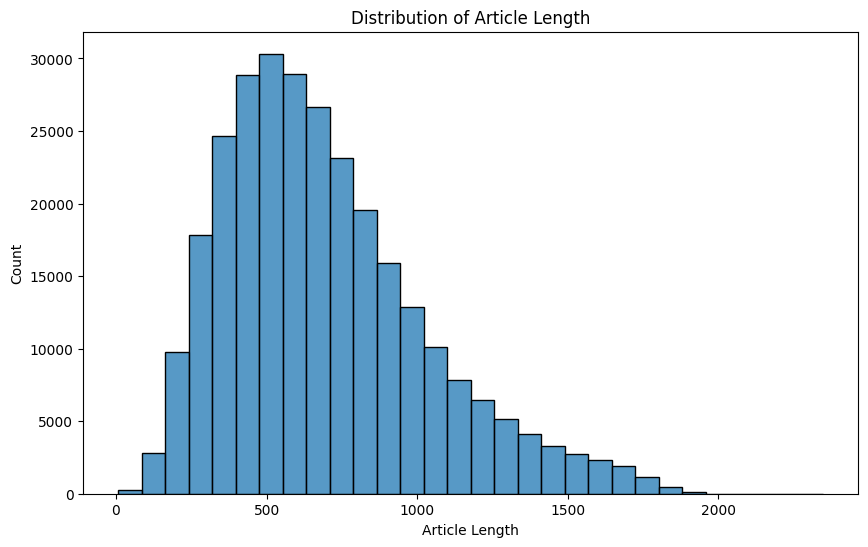

In [63]:
# Distribution of article length
train_df['article_len'] = train_df['article'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='article_len', bins=30)
plt.title("Distribution of Article Length")
plt.xlabel("Article Length")
plt.show()

In [64]:
# Balancing Check
category_counts = train_df['highlights'].value_counts()
print("Train Dataset - Category Counts:")
print(category_counts)

Train Dataset - Category Counts:
highlights
This page includes the show Transcript and the Daily Curriculum .\nUse the Transcript to help students with reading comprehension and vocabulary .\nThe Daily Curriculum offers the Media Literacy Question of the Day, Key Concepts, Fast Facts and Discussion Questions .\nAt the bottom of the page, please share your feedback about our show and curriculum .                                                                                                     83
This page includes the show Transcript, the Daily Curriculum, and Maps .\nUse the Transcript to help students with reading comprehension and vocabulary .\nThe Daily Curriculum offers the Media Literacy Question of the Day, Key Concepts, Fast Facts and Discussion Questions .\nAt the bottom of the page, please share your feedback about our show and curriculum .                                                                                              73
The daily transcript is a written versio

In [65]:
# Data Cleaning and Preprocessing (text-based EDA)
# Remove any non-alphanumeric characters and extra whitespaces
import re
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(' +', ' ', text)
    return text

train_df['article'] = train_df['article'].apply(clean_text)
train_df['highlights'] = train_df['highlights'].apply(clean_text)

In [66]:
# Check for missing data
missing_data = train_df.isnull().sum()
print("Missing Data:")
print(missing_data)

# Handle missing data if necessary

# Explore other aspects of the data (e.g., word frequency, text sentiment, etc.) as needed for your task.

# Balancing Check (if relevant)
# Check if there is an imbalance in the target variable (e.g., if you have categories)
category_counts = train_df['article_len'].value_counts()
print("Train Dataset - Category Counts:")
print(category_counts)

Missing Data:
id             0
article        0
highlights     0
article_len    0
dtype: int64
Train Dataset - Category Counts:
article_len
531     432
475     431
520     426
460     423
574     421
       ... 
1986      1
1957      1
1936      1
1874      1
32        1
Name: count, Length: 1923, dtype: int64


## INSTALLING THE REQUIRED LIBRARIES

In [67]:
# Install the required libraries if not already installed
!pip install transformers
!pip install datasets
!pip install rouge_score

## **BART OPEN-LLM MODEL**

In [68]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_metric
from rouge_score import rouge_scorer

In [69]:
# Specify the BART model name
model_name = "facebook/bart-large-cnn"

# Load the BART tokenizer and model
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

In [70]:
# Function to generate summaries
def generate_summary(article_text):
    inputs = tokenizer.encode("summarize: " + article_text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=100, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function to calculate ROUGE scores
def calculate_rouge_scores(original_summary, generated_summary):
    rouge = load_metric("rouge")
    scores = rouge.compute(predictions=[generated_summary], references=[original_summary])
    return scores

In [71]:
# Summarize and evaluate a single article from the test dataset
article = test_df.iloc[0]['article']
original_summary = test_df.iloc[0]['highlights']
generated_summary = generate_summary(article)
rouge_scores = calculate_rouge_scores(original_summary, generated_summary)

print("Original Summary:")
print(original_summary)
print("\nGenerated Summary:")
print(generated_summary)

Original Summary:
Experts question if  packed out planes are putting passengers at risk .
U.S consumer advisory group says minimum space must be stipulated .
Safety tests conducted on planes with more leg room than airlines offer .

Generated Summary:
U.S consumer advisory group set up by Department of Transportation said that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. Tests conducted by the FAA use planes with a 31 inch pitch, a standard which on some airlines has decreased.


In [72]:
# Calculate ROUGE scores
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'])
rouge_scores = rouge_scorer.score(generated_summary, original_summary)

# Print ROUGE scores line by line
for metric, scores in rouge_scores.items():
    print(f"{metric}:")
    print(f"Precision: {scores.precision}")
    print(f"Recall: {scores.recall}")
    print(f"F1 Score: {scores.fmeasure}")
    print()

rouge1:
Precision: 0.4117647058823529
Recall: 0.24561403508771928
F1 Score: 0.3076923076923077

rouge2:
Precision: 0.21212121212121213
Recall: 0.125
F1 Score: 0.15730337078651685

rougeL:
Precision: 0.35294117647058826
Recall: 0.21052631578947367
F1 Score: 0.2637362637362637

rougeLsum:
Precision: 0.38235294117647056
Recall: 0.22807017543859648
F1 Score: 0.28571428571428564



In [73]:
# Function to calculate word overlap accuracy
def calculate_accuracy(original_summary, generated_summary):
    # Split summaries into words
    original_words = set(original_summary.split())
    generated_words = set(generated_summary.split())
    
    # Calculate the intersection of words (common words)
    common_words = original_words.intersection(generated_words)
    
    # Calculate accuracy as the ratio of common words to total words in the original summary
    accuracy = len(common_words) / len(original_words) if len(original_words) > 0 else 0.0
    return accuracy

# Calculate and print accuracy
accuracy = calculate_accuracy(original_summary, generated_summary)
print(f"Word Overlap Accuracy: {accuracy:.2%}")

Word Overlap Accuracy: 33.33%


In [74]:
# Calculate and print the average ROUGE F1 score
average_f1_score = sum(scores.fmeasure for scores in rouge_scores.values()) / len(rouge_scores)
print(f"Average ROUGE F1 Score: {average_f1_score:.4f}")

Average ROUGE F1 Score: 0.2536


## **T5 (Text-to-Text Transfer Transformer)**

In [75]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [76]:
# Function to generate summaries using T5
def generate_summary(article_text):
    input_text = "summarize: " + article_text
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    summary_ids = model.generate(input_ids, max_length=100, num_beams=4, length_penalty=2.0, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function to calculate ROUGE scores
def calculate_rouge_scores(original_summary, generated_summary):
    rouge = load_metric("rouge")
    scores = rouge.compute(predictions=[generated_summary], references=[original_summary])
    return scores

# Function to calculate word overlap accuracy
def calculate_accuracy(original_summary, generated_summary):
    original_words = set(original_summary.split())
    generated_words = set(generated_summary.split())
    common_words = original_words.intersection(generated_words)
    accuracy = len(common_words) / len(original_words) if len(original_words) > 0 else 0.0
    return accuracy

# Evaluate the model on a sample article
sample_index = 0  # Change this to evaluate other articles
article = test_df.iloc[sample_index]['article']
original_summary = test_df.iloc[sample_index]['highlights']
generated_summary = generate_summary(article)

# Calculate ROUGE scores
rouge_scores = calculate_rouge_scores(original_summary, generated_summary)

# Calculate word overlap accuracy
accuracy = calculate_accuracy(original_summary, generated_summary)

# Print the results
print("Original Summary:")
print(original_summary)
print("\nGenerated Summary:")
print(generated_summary)

Original Summary:
Experts question if  packed out planes are putting passengers at risk .
U.S consumer advisory group says minimum space must be stipulated .
Safety tests conducted on planes with more leg room than airlines offer .

Generated Summary:
U.S consumer advisory group set up by the Department of Transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. Tests conducted by the FAA use planes with a 31 inch pitch, a standard which on some airlines has decreased.


In [77]:
# Calculate ROUGE scores
from rouge_score import rouge_scorer

# Define ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'])

# Calculate ROUGE scores
rouge_scores = scorer.score(generated_summary, original_summary)

# Print ROUGE scores
for metric, scores in rouge_scores.items():
    print(f"{metric}:")
    print(f"Precision: {scores.precision:.4f}")
    print(f"Recall: {scores.recall:.4f}")
    print(f"F1 Score: {scores.fmeasure:.4f}")
    print()

rouge1:
Precision: 0.4412
Recall: 0.2419
F1 Score: 0.3125

rouge2:
Precision: 0.2121
Recall: 0.1148
F1 Score: 0.1489

rougeL:
Precision: 0.3529
Recall: 0.1935
F1 Score: 0.2500

rougeLsum:
Precision: 0.3824
Recall: 0.2097
F1 Score: 0.2708



In [78]:
print(f"Word Overlap Accuracy: {accuracy:.2%}")

Word Overlap Accuracy: 36.36%


In [87]:
# Calculate and print the average ROUGE F1 score
average_f1_score = sum(scores.fmeasure for scores in rouge_scores.values()) / len(rouge_scores)
print(f"Average ROUGE F1 Score: {average_f1_score:.4f}")

Average ROUGE F1 Score: 0.2456


## **DistilBERT**

In [79]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import load_metric
from rouge_score import rouge_scorer

In [80]:
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
# Function to generate summaries using DistilBERT
def generate_summary(article_text, max_length=100):
    # Tokenize and generate the summary
    inputs = tokenizer.encode("summarize: " + article_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function to calculate ROUGE scores
def calculate_rouge_scores(original_summary, generated_summary):
    # Import the necessary library
    from rouge_score import rouge_scorer
    
    # Initialize the ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'])
    
    # Calculate ROUGE scores
    rouge_scores = scorer.score(generated_summary, original_summary)
    return rouge_scores

In [82]:
# Calculate ROUGE scores
rouge_scores = calculate_rouge_scores(original_summary, generated_summary)

# Print the ROUGE scores
for metric, score in rouge_scores.items():
    print(f"{metric}:")
    print(f"Precision: {score.precision:.4f}")
    print(f"Recall: {score.recall:.4f}")
    print(f"F1 Score: {score.fmeasure:.4f}")
    print()

rouge1:
Precision: 0.4412
Recall: 0.2419
F1 Score: 0.3125

rouge2:
Precision: 0.2121
Recall: 0.1148
F1 Score: 0.1489

rougeL:
Precision: 0.3529
Recall: 0.1935
F1 Score: 0.2500

rougeLsum:
Precision: 0.3824
Recall: 0.2097
F1 Score: 0.2708



In [86]:
# Calculate and print the average ROUGE F1 score
average_f1_score = sum(scores.fmeasure for scores in rouge_scores.values()) / len(rouge_scores)
print(f"Average ROUGE F1 Score: {average_f1_score:.4f}")

Average ROUGE F1 Score: 0.2456
